# Notebook for regridding using xarray to compare WRF HIST and MRMS MESH

### Read in geometry and apply coarsen to WRF lats/lons:

In [1]:
import xarray as xr

geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc") #Open WRF lat/lon coords file

coarse_geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean() #Find mean lat/lon of grid runs: averaging over 20 pixels is
                                                                                                    #roughly equivalent to 75 km (20 * 3.75 km = 75)

### New dimensions of lat/lon data are now 44 x 69 after averaging across 20 pixels (mean lat/lon of the 20th pixel run, or centroid)

## Use WRF HIST data to validate that this method upscales original data to ~75 x 75 km grid

In [2]:
wrf_hist = xr.open_mfdataset('/home/scratch/ahaberlie/AFWA_HAIL/HIST/*/*.nc') #Open WRF daily max file
wrf_hist

<xarray.Dataset>
Dimensions:     (Time: 131007, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-10-01 ... 2005-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 dask.array<chunksize=(24, 899, 1399), meta=np.ndarray>
Attributes: (12/93)
    TITLE:                            OUTPUT FROM WRF V4.1.2 MODEL
    START_DATE:                      1990-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1400
    SOUTH-NORTH_GRID_DIMENSION:      900
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              3750.0
    ...                              ...
    file_count:                      24
    first_file:                      /gpfs/csfs1/univ/unid0001/historical/199...
    last_file:                       /gpfs/csfs1/univ/unid0001/historical/199...
    first_time:                      1990-10-01T00:00:00.000000000
    last_time:                       1990-10-01T23:00:00.000000000
    sim:                             historical

## Resample to convective daily max

In [3]:
wrf_daily_max = wrf_hist.resample(Time='24H', base=12).max()
wrf_daily_max #Returns 5479 days (4 leap days)

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 899, 1399), meta=np.ndarray>

## Pass severe hail threshold (can switch this out for large hail [≥ 1.57 in; 4 cm] as well)

In [6]:
sev_hail_days = 1 * (wrf_daily_max >= 0.0254) #Pass day threshold to this variable
sev_hail_days

<xarray.Dataset>
Dimensions:     (Time: 5479, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1990-09-30T12:00:00 ... 2005-09-29T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 dask.array<chunksize=(1, 899, 1399), meta=np.ndarray>

### Compute hail days to work with later

In [7]:
import dask.array as da
from dask import delayed
import dask.dataframe as dd
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 755.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37852,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 755.66 GiB
Comm: tcp://127.0.0.1:40441,Total threads: 8
Dashboard: http://127.0.0.1:35095/status,Memory: 94.46 GiB
Nanny: tcp://127.0.0.1:41447,


In [8]:
sev_hail_days = sev_hail_days.compute()

## Groupby season to find seasonal sev hail days

In [9]:
seasonal_max = sev_hail_days.groupby('Time.season')
seasonal_max

DatasetGroupBy, grouped over 'season'
4 groups with labels 'DJF', 'JJA', 'MAM', 'SON'.

### Select by season for plotting

In [10]:
wrf_DJF = seasonal_max['DJF']
wrf_MAM = seasonal_max['MAM']
wrf_JJA = seasonal_max['JJA']
wrf_SON = seasonal_max['SON']

In [13]:
wrf_MAM #Returns # of days in 3-month season x 899 x 1399

<xarray.Dataset>
Dimensions:     (Time: 1380, south_north: 899, west_east: 1399)
Coordinates:
  * Time        (Time) datetime64[ns] 1991-03-01T12:00:00 ... 2005-05-31T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

## Plot summed hail day counts to new grid

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline

"""
plt.rcParams['figure.figsize'] = 10, 10

geog_test_hail = deepcopy(geog[['CLAT', 'CLONG']])

geog_test_hail['sev_hail_days'] = (('Time', 'south_north', 'west_east'), np.array([sev_hail_days]))

plt.imshow(geog_test_hail['sev_hail_days'].values[0,:,:])
"""

"\nplt.rcParams['figure.figsize'] = 10, 10\n\ngeog_test_hail = deepcopy(geog[['CLAT', 'CLONG']])\n\ngeog_test_hail['sev_hail_days'] = (('Time', 'south_north', 'west_east'), np.array([sev_hail_days]))\n\nplt.imshow(geog_test_hail['sev_hail_days'].values[0,:,:])\n"

# Coarsen the data

### NOTE: must coarsen MESH data to different number of pixels since resolution isn't the same- both must be (44 x 69)

In [43]:
hail_day_coarse = sev_hail_days.coarsen(south_north=20, west_east=20, boundary='trim').max()
#wrf_DJF_coarse = wrf_DJF.coarsen(south_north=20, west_east=20, boundary='trim').max()
#wrf_MAM_coarse = wrf_MAM.coarsen(south_north=20, west_east=20, boundary='trim').max()
#wrf_JJA_coarse = wrf_JJA.coarsen(south_north=20, west_east=20, boundary='trim').max()
#wrf_SON_coarse = wrf_SON.coarsen(south_north=20, west_east=20, boundary='trim').max()

In [16]:
wrf_MAM_coarse #Make sure new lats/lons are (44 x 69)

<xarray.Dataset>
Dimensions:     (Time: 1380, south_north: 44, west_east: 69)
Coordinates:
  * Time        (Time) datetime64[ns] 1991-03-01T12:00:00 ... 2005-05-31T12:0...
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (Time, south_north, west_east) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0

## Sum along 'Time' dimension (simulation year) to get hail day count for each grid

In [44]:
annual_sum = hail_day_coarse.sum(dim = 'Time')
#wrf_DJF_sum = wrf_DJF_coarse.sum(dim = 'Time')
#wrf_MAM_sum = wrf_MAM_coarse.sum(dim = 'Time')
#wrf_JJA_sum = wrf_JJA_coarse.sum(dim = 'Time')
#wrf_SON_sum = wrf_SON_coarse.sum(dim = 'Time')

In [18]:
wrf_DJF_sum

<xarray.Dataset>
Dimensions:     (south_north: 44, west_east: 69)
Dimensions without coordinates: south_north, west_east
Data variables:
    HAIL_MAX2D  (south_north, west_east) int64 1 0 0 0 0 1 ... 21 34 46 28 24 20

### Divide by 15 (6.5833 for mesh) to get mean annual statistic

#### NOTE: MESH data begins 20 May, 2015, so dividing by an even 7 will not provide a correct annual statistic

In [45]:
annual_stat = annual_sum / 15
#wrf_DJF_stat = wrf_DJF_sum / 15
#wrf_MAM_stat = wrf_MAM_sum / 15
#wrf_JJA_stat = wrf_JJA_sum / 15
#wrf_SON_stat = wrf_SON_sum / 15

### Select HAIL_MAX2D variable to create plottable 2D array

In [46]:
annual_stat_plot = annual_stat.HAIL_MAX2D
#wrf_DJF_stat_plot = wrf_DJF_stat.HAIL_MAX2D
#wrf_MAM_stat_plot = wrf_MAM_stat.HAIL_MAX2D
#wrf_JJA_stat_plot = wrf_JJA_stat.HAIL_MAX2D
#wrf_SON_stat_plot = wrf_SON_stat.HAIL_MAX2D

In [24]:
wrf_JJA_stat_plot.max()

<xarray.DataArray 'HAIL_MAX2D' ()>
array(72.33333333)

## Plot on map of CONUS

/tmp/ipykernel_62235/1554009535.py:42: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_over('lemonchiffon')
/anaconda3/envs/pyEAE/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


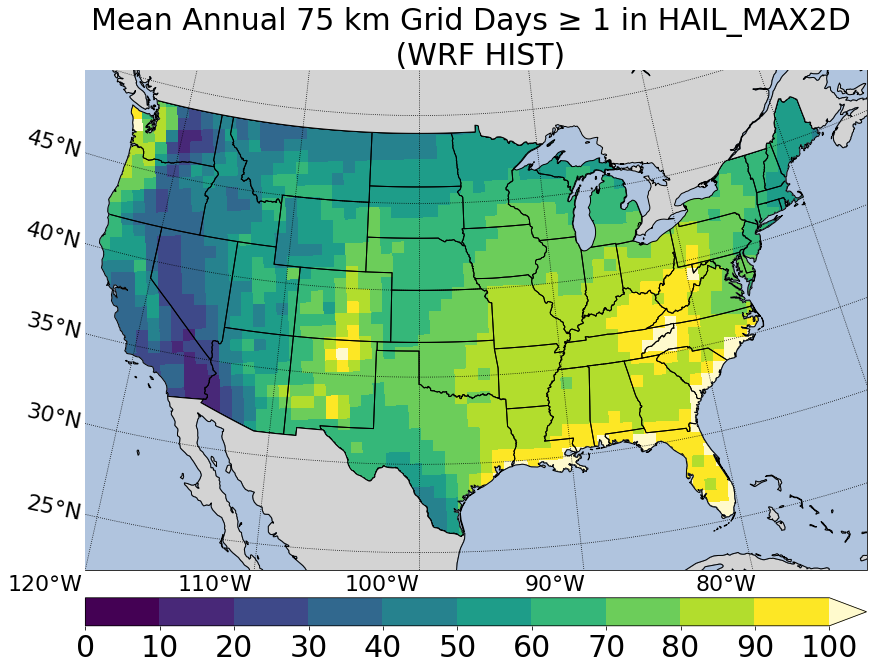

2022-11-17 22:53:19,042 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-17 22:53:19,042 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-17 22:53:19,042 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-17 22:53:19,043 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-17 22:53:19,043 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-17 22:53:19,043 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-17 22:53:19,044 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-17 22:53:19,044 - distributed.nanny - ERROR - Worker process died unexpectedly
2022-11-17 22:53:20,488 - distributed.nanny - WARNING - Restarting worker


In [49]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

fig = plt.figure(figsize= (14,10)) #Plot a figure
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, .05], bottom=.05, top=.95, wspace=.1)
map_proj = ccrs.LambertConformal(central_longitude = -100, central_latitude = 35) #Set projection, central lat/lon
ax = plt.subplot(projection = map_proj)
ax.set_extent([240,287,22,50])
ax.add_feature(cfeature.LAND.with_scale('10m')) #Add land
countries_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural',
                                     name='admin_0_countries')
for country, info in zip(shpreader.Reader(countries_shp).geometries(), 
                             shpreader.Reader(countries_shp).records()):
        if info.attributes['NAME_LONG'] != 'United States':

            ax.add_geometries([country], ccrs.PlateCarree(),
                             facecolor='lightgrey', edgecolor='k', zorder=6)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='k', 
                                                facecolor='None'), zorder=8) 
ax.add_feature(cfeature.BORDERS.with_scale('10m')) #Add state borders
ax.add_feature(cfeature.STATES.with_scale('10m'), facecolor = 'none') #Add US states
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', 
                                                facecolor='lightsteelblue'), zorder=6)
lakes_shp = shpreader.natural_earth(resolution='50m',
                                     category='physical',
                                     name='lakes')
for lake, info in zip(shpreader.Reader(lakes_shp).geometries(), 
                             shpreader.Reader(lakes_shp).records()):
        name = info.attributes['name']
        if name == 'Lake Superior' or name == 'Lake Michigan' or \
           name == 'Lake Huron' or name == 'Lake Erie' or name == 'Lake Ontario':
            
            ax.add_geometries([lake], ccrs.PlateCarree(),
                             facecolor='lightsteelblue', edgecolor='k', zorder=6)
            
cmap = cm.get_cmap('viridis')
cmap.set_over('lemonchiffon')
levels = np.arange(0, 110, 10)

mmp = ax.pcolormesh(coarse_geog['CLONG'].values[0,:,:], coarse_geog['CLAT'].values[0,:,:], annual_stat_plot, 
              shading='nearest', transform=ccrs.PlateCarree(), cmap=cmap, vmin=levels[1], norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, 
                                                                                                                                    clip=False)) #alpha=0.5)

gls = ax.gridlines(draw_labels=True, dms = True, x_inline=False, y_inline=False, color="black", linestyle="dotted", zorder = 10)
gls.top_labels=False
gls.right_labels=False
gls.xlabel_style = {'size': 22, 'rotation': 0}
gls.xpadding = 15.0
gls.ylabel_style = {'size': 22}
plt.title("Mean Annual 75 km Grid Days ≥ 1 in HAIL_MAX2D \n (WRF HIST)", fontsize = 30)
ax2 = plt.subplot(gs1[1, 0]) 
#bounds = [0, 10, 20, 30, 40, 50]
#norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = plt.colorbar(mmp, cax = ax2, ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], orientation = 'horizontal', extend = 'max')
#cb.set_label('Days', fontsize = 30)
cb.ax.tick_params(labelsize = 30)
plt.subplots_adjust(bottom=0.07)
#plt.tight_layout()
#plt.savefig('/home/scratch/jgoodin/compare_wrf_mesh/wrf_annual_75km_hail_days.png') #**Make sure to save results to png!**